
# 1.Instalação e carga de pacotes necessários

In [35]:
%pip install sentence_transformers


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\lucas\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [36]:
%pip install pandas


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\lucas\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [37]:
%pip install numpy


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\lucas\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [38]:
%pip install matplotlib


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\lucas\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [39]:
%pip install seaborn


In [ ]:
import sentence_transformers
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


In [ ]:
#instalação do Ulysses Fetcher, para buscar os datasets no Github do projeto
!python -m pip install "git+https://github.com/ulysses-camara/ulysses-fetcher@v0.1.1-beta"
import buscador



  Cloning https://github.com/ulysses-camara/ulysses-fetcher (to revision v0.1.1-beta) to c:\users\lucas\appdata\local\temp\pip-req-build-1r64efbs
  Resolved https://github.com/ulysses-camara/ulysses-fetcher to commit 933107853f4794beb2ffbd99ec4c25437e569aea
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/ulysses-camara/ulysses-fetcher 'C:\Users\lucas\AppData\Local\Temp\pip-req-build-1r64efbs'
  Running command git checkout -q 933107853f4794beb2ffbd99ec4c25437e569aea
You should consider upgrading via the 'c:\Users\lucas\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


# 6. Implementação da API do BM25L + RF para comparação.

In [ ]:
#Importando a biblioteca nltk

import nltk

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('rslp')

import sklearn

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lucas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lucas\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\lucas\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!


In [ ]:
#Algoritmo do BM25 Okapi

import math
import numpy as np
from multiprocessing import Pool, cpu_count

"""
All of these algorithms have been taken from the paper:
Trotmam et al, Improvements to BM25 and Language Models Examined
Here we implement all the BM25 variations mentioned. 
"""


class BM25:
    def __init__(self, corpus, tokenizer=None):
        self.corpus_size = len(corpus)
        self.avgdl = 0
        self.doc_freqs = []
        self.idf = {}
        self.doc_len = []
        self.tokenizer = tokenizer
        #Tokenizar o corpus
        if tokenizer:
            corpus = self._tokenize_corpus(corpus)

        nd = self._initialize(corpus)
        self._calc_idf(nd)

    def _initialize(self, corpus):
        nd = {}  # word -> number of documents with word
        num_doc = 0
        for document in corpus:
            self.doc_len.append(len(document))
            num_doc += len(document)

            frequencies = {}
            for word in document:
                if word not in frequencies:
                    frequencies[word] = 0
                frequencies[word] += 1
            self.doc_freqs.append(frequencies)

            for word, freq in frequencies.items():
                try:
                    nd[word] += 1
                except KeyError:
                    nd[word] = 1

        self.avgdl = num_doc / self.corpus_size

        return nd

    def _tokenize_corpus(self, corpus):
        pool = Pool(cpu_count())
        tokenized_corpus = pool.map(self.tokenizer, corpus)
        return tokenized_corpus

    def _calc_idf(self, nd):
        raise NotImplementedError()

    def get_scores(self, query):
        raise NotImplementedError()

    def get_batch_scores(self, query, doc_ids):
        raise NotImplementedError()

    def get_top_n(self, query, documents, n=5):

        assert self.corpus_size == len(documents), "The documents given don't match the index corpus!"

        scores = self.get_scores(query)
        top_n = np.argsort(scores)[::-1][:n]
        return [documents[i] for i in top_n]

    def get_top_n_ngram(self, score, documents, n=5):

        assert self.corpus_size == len(documents), "The documents given don't match the index corpus!"

        pdr = np.zeros(self.corpus_size)
        alpha = 2
        for ps in score:
            pdr = np.add(pdr, alpha * ps)
            alpha -= 1

        top_n = np.argsort(pdr)[::-1][:n]
        return [documents[i] for i in top_n]

    def get_partial_score(self, query, documents):
        assert self.corpus_size == len(documents), "The documents given don't match the index corpus!"

        score = self.get_scores(query)

        return score

    def get_top_n_score(self, scores, documents, n=5):

        assert self.corpus_size == len(documents), "The documents given don't match the index corpus!"

        top_n = np.argsort(scores)[::-1][:n]
        return [documents[i] for i in top_n]

In [ ]:
#Implementacao do BM25L - adapta parametros para corrigir a preferencia do Okapi por documentos mais curtos

class BM25L(BM25):
    def __init__(self, corpus, tokenizer=None, k1=2.4, b=0.9, epsilon=0.25):
        self.k1 = k1
        self.b = b
        self.epsilon = epsilon
        super().__init__(corpus, tokenizer)

    #Calculo do IDF (Inverse Document Frequency)
    def _calc_idf(self, nd):
        """
        Calculates frequencies of terms in documents and in corpus.
        This algorithm sets a floor on the idf values to eps * average_idf
        """
        # collect idf sum to calculate an average idf for epsilon value
        idf_sum = 0
        # collect words with negative idf to set them a special epsilon value.
        # idf can be negative if word is contained in more than half of documents
        negative_idfs = []
        for word, freq in nd.items():
            idf = math.log(self.corpus_size + 1) - math.log(freq + 0.5)
            self.idf[word] = idf
            idf_sum += idf
            if idf < 0:
                negative_idfs.append(word)
        self.average_idf = idf_sum / len(self.idf)

        eps = self.epsilon * self.average_idf
        for word in negative_idfs:
            self.idf[word] = eps
    
    #Calculo do ctd
    def get_ctd(self, q_freq, b, doc_len, avg_len):
      ctd = q_freq/(1 - b + b*(doc_len)/(avg_len))
      return ctd

    #Avaliar a pontuacao de todos os documentos na base
    def get_scores(self, query):
        """
        The ATIRE BM25 variant uses an idf function which uses a log(idf) score. To prevent negative idf scores,
        this algorithm also adds a floor to the idf value of epsilon.
        See [Trotman, A., X. Jia, M. Crane, Towards an Efficient and Effective Search Engine] for more info
        :param query:
        :return:
        """
        score = np.zeros(self.corpus_size)
        doc_len = np.array(self.doc_len)

        for q in query:
            q_freq = np.array([(doc.get(q) or 0) for doc in self.doc_freqs])
            ctd = self.get_ctd(q_freq, self.b, doc_len, self.avgdl)
            score += (self.idf.get(q) or 0) * ( (ctd + 0.5) * (self.k1 + 1) /
                                               ( (ctd + 0.5) + self.k1 ))
        return score

    def get_batch_scores(self, query, doc_ids):
        """
        Calculate bm25 scores between query and subset of all docs
        """
        assert all(di < len(self.doc_freqs) for di in doc_ids)
        score = np.zeros(len(doc_ids))
        doc_len = np.array(self.doc_len)[doc_ids]
        for q in query:
            q_freq = np.array([(self.doc_freqs[di].get(q) or 0) for di in doc_ids])
            score += (self.idf.get(q) or 0) * (q_freq * (self.k1 + 1) /
                                               (q_freq + self.k1 * (1 - self.b + self.b * doc_len / self.avgdl)))
        return score.tolist()
        
    def lambda_update(self, scores, lambdas, data):
        """
        Updates bm25 scores using the lambdas values
        """
        data = data[data["txt_ementa"].notna()]
        data.reset_index(inplace=True)

        for i in range(len(data)):
            nome_doc = data["name"][i].strip()
            if nome_doc in lambdas.keys():
                scores[i] += lambdas[nome_doc]

        return scores

    def lambda_calc(self, queries_ds, query, cut, delta):
        """
        Searches for similar queries; returns dictionary
        """
        # CSV treatment
        
        all_queries = queries_ds["query"].tolist()
        all_queries.append(query)
        lista_doc = list()
        for f in queries_ds["user_feedback"]:
            lista_d = list()
            documents = list(eval(f))
            for d in documents:
                lista_d.append('{0}, {1}, {2}'.format(str(d['id']), str(d['score']),str(d['score_normalized'])))
            lista_doc.append(lista_d)

        vectorizer = TfidfVectorizer()
        vectorizer.fit(all_queries)
        vsm_2 = vectorizer.transform(queries_ds["query"].tolist())
        vsm_1 = vectorizer.transform([query])
        similarities = cosine_similarity(vsm_1, vsm_2).tolist()[0]

        doc_sim = [(lista_doc[j], similarities[j]) for j in range(len(similarities)) if similarities[j] > cut]
        dic = {}
        for tuple in doc_sim:
            for doc in tuple[0]:
                l = doc.split(",")
                if l[0] in dic:
                    dic[l[0].strip().replace("'", "")] += float(l[2]) * float(tuple[1])
                else:
                    dic[l[0].strip().replace("'", "")] = float(l[2]) * float(tuple[1])  # calculando a soma do produto sim*score

        for key in dic:
            dic[key] = np.log(dic[key] + 1) * delta
        return dic


In [ ]:
"""# carregando corpus

# Selecting list of documents to be read
input_file = "usp_corpus_20220714.csv"      # must be replaced with a file containing the corpus
mylist = []

for chunk in  pd.read_csv(input_file, chunksize=2000):
    mylist.append(chunk)

df = pd.concat(mylist, axis= 0)
del mylist
df.reset_index(inplace=True)"""

In [ ]:
df = pd.read_csv("usp_corpus_20220714.csv")
data = df.txt_ementa.dropna()        # Trocar com nome da coluna desejada
data = data.to_numpy()

In [ ]:
from nltk.tokenize import word_tokenize
from string import punctuation
import nltk
from unicodedata import normalize
from nltk.stem import RSLPStemmer
from nltk.util import ngrams
from nltk.tokenize import RegexpTokenizer

# Remove os acentos de uma string
def _remove_acentos(txt):
    return normalize('NFKD', txt).encode('ASCII', 'ignore').decode('ASCII')

# Remoção de stopwords + acentuação
def preprocess2(txt):
    txt = _remove_acentos(txt)
    stopwords = nltk.corpus.stopwords.words("portuguese")
    stopwords.extend(list(punctuation))
    
    # terms = word_tokenize(txt.lower())
    tokenizer = RegexpTokenizer('\w+')
    terms = tokenizer.tokenize(txt.lower())
    terms = [word for word in terms if word not in stopwords]

    return terms

# Remoção de stopwords + acentuação + steming
def preprocess3(txt):
    txt = _remove_acentos(txt)
    stopwords = nltk.corpus.stopwords.words("portuguese")
    stopwords.extend(list(punctuation))

    stemmer = RSLPStemmer()
    # terms = word_tokenize(txt.lower())
    tokenizer = RegexpTokenizer('\w+')
    terms = tokenizer.tokenize(txt.lower())
    terms = [stemmer.stem(word) for word in terms if word not in stopwords]
    return terms

# Remoção de stopwords + acentuação + n-gram
def preprocess_ngram(txt, n):
    txt = _remove_acentos(txt)
    stopwords = nltk.corpus.stopwords.words("portuguese")
    stopwords.extend(list(punctuation))

    # terms = word_tokenize(txt.lower())
    tokenizer = RegexpTokenizer('\w+')
    terms = tokenizer.tokenize(txt.lower())
    terms = [word for word in terms if word not in stopwords]

    ngram = list(ngrams(terms, n))

    return ngram

# Remoção de stopwords + acentuação + steming + n-gram
def preprocess_ngram_stem(txt, n):
    txt = _remove_acentos(txt)
    stopwords = nltk.corpus.stopwords.words("portuguese")
    stopwords.extend(list(punctuation))

    stemmer = RSLPStemmer()
    # terms = word_tokenize(txt.lower())
    tokenizer = RegexpTokenizer('\w+')
    terms = tokenizer.tokenize(txt.lower())
    terms = [stemmer.stem(word) for word in terms if word not in stopwords]

    ngram = list(ngrams(terms, n))

    return ngram

In [ ]:
tokenized_corpus3 = [preprocess3(doc) for doc in data]                      #Stopwords + Acentuação + Stemming

In [ ]:
bm25L = BM25L(tokenized_corpus3)              #Stopwords + Acentuação + Stemming

In [ ]:
# Pesquisando por assuntos
df_assunto = pd.read_csv("usp_feedback_20220714_com_ponto.csv", delimiter=',', encoding="utf-8")
df_assunto.dropna(inplace=True)
df_assunto.reset_index(inplace=True)
df_assunto.drop(columns=["index"], inplace=True)

In [ ]:
# Obtem o nome do texto no df
def get_name(df, doc):
    return str(df[df.txt_ementa==doc].name.to_numpy()[0]).strip()

In [ ]:

y = df_assunto["id"].to_list()
X = df_assunto["query"].to_list()
y = [i.strip() for i in y]

In [ ]:
base_feedback = pd.read_csv('usp_feedback_20220714_com_ponto.csv')

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

labels_old = list()
labels_new = list()

l_v = list()

for l, x in zip(y, X):
    tokenized_query = preprocess3(x)  # Stopwords + Acentuação + Stemming

    # Stopwords + Acentuação + Stemming + Unigram + Bigram (L)
    scores_stem_l = list()

    # Cálculo dos lambdas para a query
    lambdas = bm25L.lambda_calc(base_feedback, x, cut=0.6, delta=0.7)

    # Processo normal do BM25
    scores = bm25L.get_partial_score(tokenized_query, data)
    scores_norm = (scores - np.min(scores)) / (np.max(scores) - np.min(scores))

    top_n_old = bm25L.get_top_n_score(scores_norm, data, n=20)
    label_old = [get_name(df, d) for d in top_n_old]

    # Cálculo dos novos scores; seleção dos n documentos com base nos scores novos
    new_scores = bm25L.lambda_update(scores_norm, lambdas, df)
    top_n_new = bm25L.get_top_n_score(new_scores, data, n=20)
    label_new = [get_name(df, d) for d in top_n_new]

    

    # Adicionar os resultados da query as listas

    labels_old.append(label_old)
    labels_new.append(label_new)
    # Adicionar resposta esperada a lista
    l_v.append(l)


# 7. A partir daqui seguem as avaliações de recall dos modelos.

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Seguindo uma lógica semelhante à da API do BM25 
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; O primeiro passo é a criação de uma lista com o "nome" dos N textos melhor ranqueados na etapa de IR. Essa lista é, depois, utilizada para a avaliação.

In [ ]:
res_old = list()
res_new = list()

for k in labels_old:

    result_old = list()

    for i in range(20):
        lista_e = eval(df_assunto["user_feedback"][i])
        if (k[i] in pd.DataFrame(data=lista_e)['name'].to_list()):
            result_old.append(1)
        else:
            result_old.append(0)

        res_old.append(sum(result_old)/len(result_old))

for k in labels_new:

    result_new = list()
    
    for i in range(20):
        lista_e = eval(df_assunto["user_feedback"][i])
        if (k[i] in pd.DataFrame(data=lista_e)['name'].to_list()):
            result_new.append(1)
        else:
            result_new.append(0)

    res_new.append(sum(result_new)/len(result_new))

In [ ]:
'''
Exibe a acuracia do algoritmo
'''


print("BM25L")
print(f"Quantidade encontrada: {sum(result_old)}")
"""print(f"Quantidade total: {len(arr_assunto)}")"""
print(f"Acurácia 10 docs: {res_old[9]}")
print(f"Acurácia 20 docs: {res_old[-1]}\n\n")

print("BM25L + LAMBDA")
print(f"Quantidade encontrada: {sum(result_new)}")
"""print(f"Quantidade total: {len(arr_assunto)}")"""
print(f"Acurácia 10 docs: {res_new[9]}")
print(f"Acurácia 20 docs: {res_new[-1]}\n\n")

"""print("LBert")
print(f"Quantidade encontrada: {sum(result_bert)}")
print(f"Quantidade total: {len(arr_assunto)}")
print(f"Acurácia 10 docs: {res_bert[9]}")
print(f"Acurácia 20 docs: {res_bert[-1]}\n\n")"""


BM25L
Quantidade encontrada: 3
Acurácia 10 docs: 1
Acurácia 20 docs: 3


BM25L + LAMBDA
Quantidade encontrada: 5
Acurácia 10 docs: 2
Acurácia 20 docs: 5




'print("LBert")\nprint(f"Quantidade encontrada: {sum(result_bert)}")\nprint(f"Quantidade total: {len(arr_assunto)}")\nprint(f"Acurácia 10 docs: {res_bert[9]}")\nprint(f"Acurácia 20 docs: {res_bert[-1]}\n\n")'

(array([1., 0., 0., 1., 0., 0., 1., 0., 0., 1.]),
 array([1. , 1.3, 1.6, 1.9, 2.2, 2.5, 2.8, 3.1, 3.4, 3.7, 4. ]),
 <BarContainer object of 10 artists>)

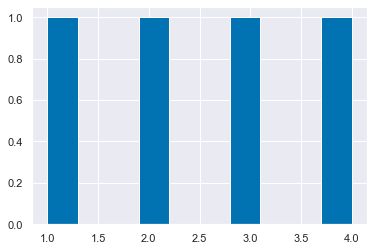

In [ ]:
sns.set(palette='colorblind')

plt.figure(figsize=(20,10))
plt.plot(np.arange(1,21), res_old, label="BM25L")
plt.plot(np.arange(1,21), res_new, label="BM25L + LAMBDA")

plt.title("")
plt.legend()
plt.ylabel("Target in Docs")
plt.xlabel("Top K Docs")
plt.show()


# 8. Geração de gráficos para visualização dos resultados.

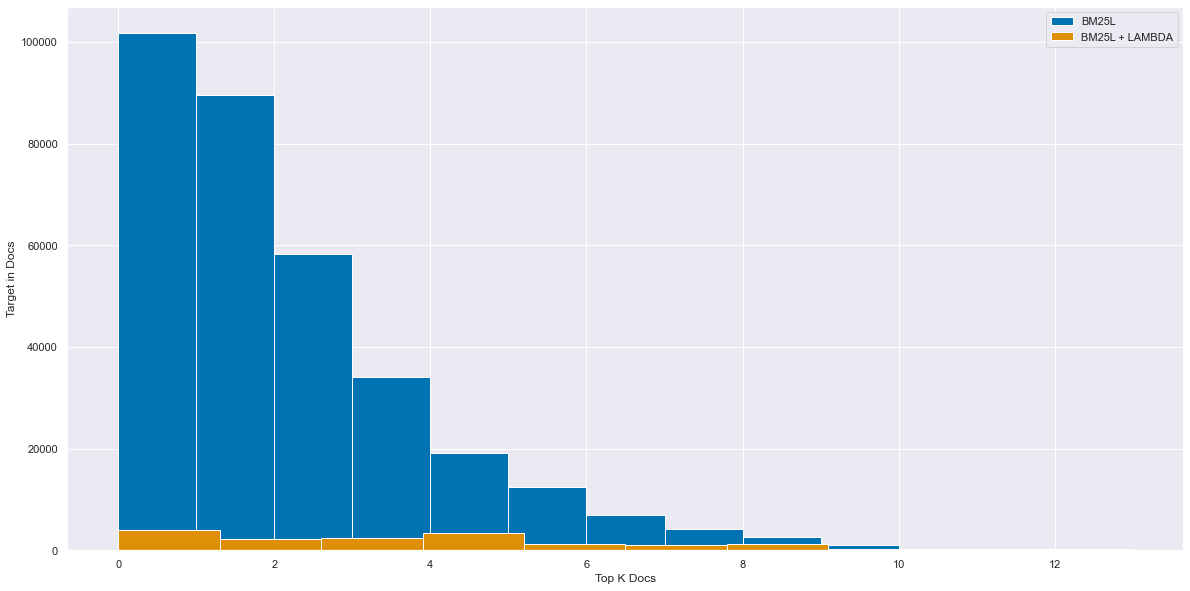

In [ ]:
sns.set(palette='colorblind')


plt.figure(figsize=(20,10))
plt.hist(res_old, label="BM25L")
plt.hist(res_new, label="BM25L + LAMBDA")

plt.title("")
plt.legend()
plt.ylabel("Target in Docs")
plt.xlabel("Top K Docs")
plt.show()


# 9. Conclusão
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; A performance do LegalBert é muito inferior à do BM25. É de conhecimento que das 307 queries restantes no dataset dos dados conle após a deleção dos campos nulos, 36 delas não estão presentes no dataset de proposições. Ainda assim, os resultados obtidos após alguns testes ainda apontam com consistência a superioridade do BM25 para o microsserviço em questão.